In [21]:
import utils
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

### Load tracks csv for metadata

In [4]:
features = utils.load('features.csv')
tracks = pd.read_csv('tracks.csv')
tracks.columns = tracks.iloc[0]
tracks = tracks.drop([0, 1])
new_cols = tracks.columns.values
new_cols[0] = 'track_id'
tracks.columns = new_cols
tracks = tracks.reset_index(drop=True)
features = features.reset_index()

/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Import pickled mfcc features

In [5]:
mfcc = pickle.load(open('mfcc.pkl', 'rb'))
mfcc[0]

array([[-2.25310822e+02, -1.38351990e+02, -1.14121765e+02, ...,
         1.88393764e+01,  2.74668903e+01, -4.20031595e+00],
       [ 1.47226013e+02,  1.09761940e+02,  8.60581970e+01, ...,
         3.29497681e+01,  3.15308647e+01,  3.74996147e+01],
       [-9.10932312e+01, -7.32884598e+01, -5.58849220e+01, ...,
        -2.00935383e+01, -2.35903893e+01, -2.36109047e+01],
       ...,
       [ 1.43565893e+00,  2.43408203e-01, -6.02198601e-01, ...,
        -1.78685188e-02,  4.07983208e+00,  3.98852015e+00],
       [-1.59950428e+01, -1.68268204e+01, -1.50425673e+01, ...,
        -1.85527456e+00, -2.85183334e+00, -8.66340828e+00],
       [ 5.29949188e-01, -1.19427252e+00, -1.96158552e+00, ...,
         8.85653305e+00,  3.91285276e+00, -7.08737373e-01]], dtype=float32)

### Delete null values, some mp3 files are corrupted. Then pad some frames so they all have equal dimensions. Split training, val, test

In [6]:
mfcc_df = pd.DataFrame(mfcc)
index_nan = np.argwhere(pd.isnull(mfcc))
mfcc_df = mfcc_df.dropna()
mfcc = mfcc_df.to_numpy().ravel()

for i in range(len(mfcc)):
    mfcc[i] = np.append(mfcc[i], np.zeros((20, 1293 - mfcc[i].shape[1])), axis=1)
    
index_nan = index_nan.ravel()

In [7]:
tracks = tracks.loc[tracks['subset'] == 'small']
tracks = tracks.reset_index()
tracks = tracks.drop(index_nan)
tracks = tracks.reset_index()

In [8]:
y_train = tracks.loc[(tracks['split'] == 'training')]['genre_top']
y_val = tracks.loc[(tracks['split'] == 'validation')]['genre_top']
y_test = tracks.loc[(tracks['split'] == 'test')]['genre_top']

In [9]:
index_train = y_train.index
index_val = y_val.index
index_test = y_test.index
print(index_train)
print(index_val)
print(index_test)

Int64Index([   0,    1,    2,    3,    4,    7,    8,    9,   10,   11,
            ...
            7981, 7982, 7983, 7984, 7985, 7986, 7987, 7994, 7995, 7996],
           dtype='int64', length=6397)
Int64Index([   5,   23,   28,   36,   58,   70,  117,  122,  126,  127,
            ...
            7854, 7855, 7856, 7857, 7858, 7859, 7860, 7869, 7871, 7928],
           dtype='int64', length=800)
Int64Index([   6,   39,   40,   41,   42,   43,   44,   55,   56,   64,
            ...
            7951, 7952, 7964, 7965, 7988, 7989, 7990, 7991, 7992, 7993],
           dtype='int64', length=800)


In [10]:
len(y_train) + len(y_val) + len(y_test)

7997

In [11]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=8, dtype='int32')
y_val = tf.keras.utils.to_categorical(y_val, num_classes=8, dtype='int32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=8, dtype='int32')

In [12]:
mfcc = np.stack(mfcc.ravel()).reshape(-1, 20, 1293)

In [13]:
mfcc.shape

(7997, 20, 1293)

In [14]:
mfcc = mfcc.reshape((-1, 20, 1293, 1))
mfcc.shape

(7997, 20, 1293, 1)

In [15]:
mfcc[0].shape

(20, 1293, 1)

In [16]:
X_train = mfcc[index_train]
X_val = mfcc[index_val]
X_test = mfcc[index_test]

In [17]:
len(X_train)

6397

In [18]:
y_train.shape

(6397, 8)

I'm trying this architecture from this paper: https://arxiv.org/pdf/1802.09697.pdf

### Try neural network architecture

Train on 5757 samples, validate on 640 samples
Epoch 1/100
5728/5757 [============================>.] - ETA: 0s - loss: 2.2588 - accuracy: 0.1915
Epoch 00001: val_accuracy improved from -inf to 0.20312, saving model to best_model_cnn.hdf5
5757/5757 [==============================] - 8s 1ms/sample - loss: 2.2574 - accuracy: 0.1914 - val_loss: 1.9267 - val_accuracy: 0.2031
Epoch 2/100
5696/5757 [============================>.] - ETA: 0s - loss: 1.9787 - accuracy: 0.2131
Epoch 00002: val_accuracy improved from 0.20312 to 0.26875, saving model to best_model_cnn.hdf5
5757/5757 [==============================] - 8s 1ms/sample - loss: 1.9790 - accuracy: 0.2133 - val_loss: 1.8660 - val_accuracy: 0.2688
Epoch 3/100
5696/5757 [============================>.] - ETA: 0s - loss: 1.9368 - accuracy: 0.2414
Epoch 00003: val_accuracy did not improve from 0.26875
5757/5757 [==============================] - 8s 1ms/sample - loss: 1.9375 - accuracy: 0.2416 - val_loss: 1.9630 - val_accuracy: 0.2031
Epoch 4

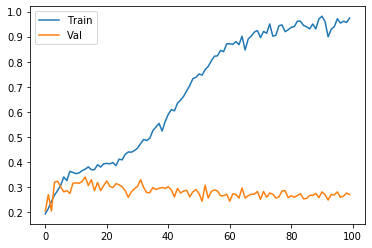

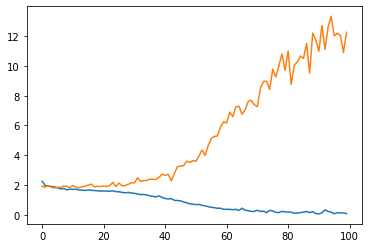

Train:
6397/1 - 4s - loss: 1.8761 - accuracy: 0.3850
[1.6606073105579358, 0.38502422]
Val:
800/1 - 0s - loss: 1.8419 - accuracy: 0.2725
[1.8672473001480103, 0.2725]


In [24]:
activation='relu'
optimizer = tf.keras.optimizers.Adam()
metrics=['accuracy']

model = tf.keras.Sequential()
model.add(Conv2D(64, kernel_size=3, strides=1, activation=activation, input_shape=(20, 1293, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(64, kernel_size=(3,5), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(32, activation=activation))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn.hdf5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

best_model = load_model('best_model_cnn.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

Train on 5757 samples, validate on 640 samples
Epoch 1/100
5728/5757 [============================>.] - ETA: 0s - loss: 3.5133 - accuracy: 0.1966 ETA: 0s - loss: 3.5208 - accuracy: 0.19
Epoch 00001: val_accuracy improved from -inf to 0.22813, saving model to best_model_cnn.hdf5
5757/5757 [==============================] - 10s 2ms/sample - loss: 3.5090 - accuracy: 0.1965 - val_loss: 2.8436 - val_accuracy: 0.2281
Epoch 2/100
5728/5757 [============================>.] - ETA: 0s - loss: 2.6710 - accuracy: 0.2573
Epoch 00002: val_accuracy improved from 0.22813 to 0.29219, saving model to best_model_cnn.hdf5
5757/5757 [==============================] - 9s 2ms/sample - loss: 2.6702 - accuracy: 0.2576 - val_loss: 2.5435 - val_accuracy: 0.2922
Epoch 3/100
5728/5757 [============================>.] - ETA: 0s - loss: 2.5270 - accuracy: 0.2572
Epoch 00003: val_accuracy did not improve from 0.29219
5757/5757 [==============================] - 9s 2ms/sample - loss: 2.5272 - accuracy: 0.2567 - val_lo

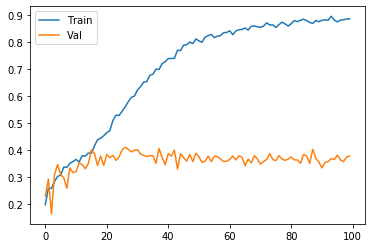

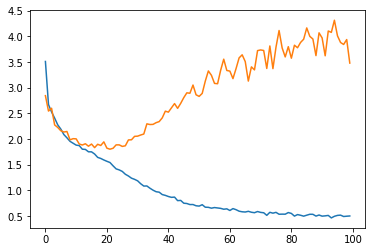

Train:
6397/1 - 4s - loss: 1.7020 - accuracy: 0.6159
[1.216009360021663, 0.6159137]
Val:
800/1 - 1s - loss: 1.6971 - accuracy: 0.3837
[1.8849267768859863, 0.38375]


In [25]:
activation='relu'
optimizer = tf.keras.optimizers.Adam()
metrics=['accuracy']

model = tf.keras.Sequential()
model.add(Conv2D(64, kernel_size=3, kernel_regularizer=tf.keras.regularizers.l2(), strides=1, activation=activation, input_shape=(20, 1293, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(64, kernel_size=(3,5), kernel_regularizer=tf.keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(32, kernel_regularizer=tf.keras.regularizers.l2(), activation=activation))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn.hdf5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

best_model = load_model('best_model_cnn.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))